# SYDE 572 Lab 1



## 2: Generating Clusters 

In [1]:
import numpy as np
from numpy.lib.function_base import cov
from numpy.core.fromnumeric import argmax,argmin
from pandas.io.sql import date
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
# set seed for consistent results
np.random.seed(1000)

In [2]:

def genCase1(dat = None):
  # dat: provided coordinates in standardized space to be converted 
  if dat is None:
    nA = 200
    datA = np.random.randn(2, nA)
    nB = 200
    datB = np.random.randn(2, nB)
  else: 
    datA = dat
    datB = dat


  # parameters
  
  muA = np.array([[5], [10]])
  covA = np.array([[8, 0], [0, 4]])

  muB = np.array([[10], [15]])
  covB = np.array([[8, 0], [0, 4]])

  # Compute eigenvalues and eigenvectors for cov. matrix
  wA, vA = np.linalg.eig(covA)
  wB, vB = np.linalg.eig(covB)

  # apply 1/sqrt(\lambda) to eigenvalues w (whitening)
  wA = 1/np.sqrt(wA)
  wB = 1/np.sqrt(wB)

  # convert to diag matrix 
  wA = np.diag(wA)
  wB = np.diag(wB)

  # calculate the inverse of W = A^-.5 \phi.T
  WinvA = np.linalg.inv(np.matmul( wA, vA.T ))
  WinvB = np.linalg.inv(np.matmul( wB, vB.T ))

  # generate
  datA = np.matmul(WinvA, datA) + muA
  datB = np.matmul(WinvB, datB) + muB

  return datA, datB

def genCase2(dat = None):
  # dat: provided coordinates in standardized space to be converted 
  if dat is None: 
    datC = np.random.randn(2, 100)
    datD = np.random.randn(2, 200)
    datE = np.random.randn(2, 150)
  else: 
    datC = dat
    datD = dat
    datE = dat

  # parameters
  covC = np.array([[8, 4], [4, 40]])
  covD = np.array([[8, 0], [0, 8]])
  covE = np.array([[10,-5], [-5, 20]])

  # Compute eigenvalues and eigenvectors for cov. matrix
  wC, vC = np.linalg.eig(covC)
  wD, vD = np.linalg.eig(covD)
  wE, vE = np.linalg.eig(covE)

  # apply 1/sqrt(\lambda) to eigenvalues w (whitening)
  wC = 1/np.sqrt(wC)
  wD = 1/np.sqrt(wD)
  wE = 1/np.sqrt(wE)

  # convert to diag matrix 
  wC = np.diag(wC)
  wD = np.diag(wD)
  wE = np.diag(wE)

  # calculate the inverse of W = A^-.5 \phi.T
  WinvC = np.linalg.inv(np.matmul( wC, vC.T ))
  WinvD = np.linalg.inv(np.matmul( wD, vD.T ))
  WinvE = np.linalg.inv(np.matmul( wE, vE.T ))

  # generate
  datC = np.matmul(WinvC, datC) + np.array([[5], [10]]) 
  datD = np.matmul(WinvD, datD) + np.array([[15], [10]]) 
  datE = np.matmul(WinvE, datE) + np.array([[10], [5]]) 

  # ### OLD METHOD
  # # decompose covariance matrix to L L^T
  # decC = np.linalg.cholesky(covC)
  # decD = np.linalg.cholesky(covD)
  # decE = np.linalg.cholesky(covE)

  # datC = np.matmul(decC, datC) + np.array([[5], [10]]) 

  # datD = np.matmul(decD, datD) + np.array([[15], [10]]) 

  # datE = np.matmul(decE, datE) + np.array([[10], [5]]) 

  return datC, datD, datE
  
def unitContour(n): 
  # generates discrete points around a unit circle
  # n: number of points 
  rad = np.linspace(0, np.pi*2, n)

  x = np.sin(rad)
  y = np.cos(rad)

  return np.row_stack((x, y))



In [3]:
# generate case data and contour data
datA, datB = genCase1()
datC, datD, datE = genCase2()

contourCoords = unitContour(100)

contourA, contourB = genCase1(contourCoords)
contourC, contourD, contourE = genCase2(contourCoords)

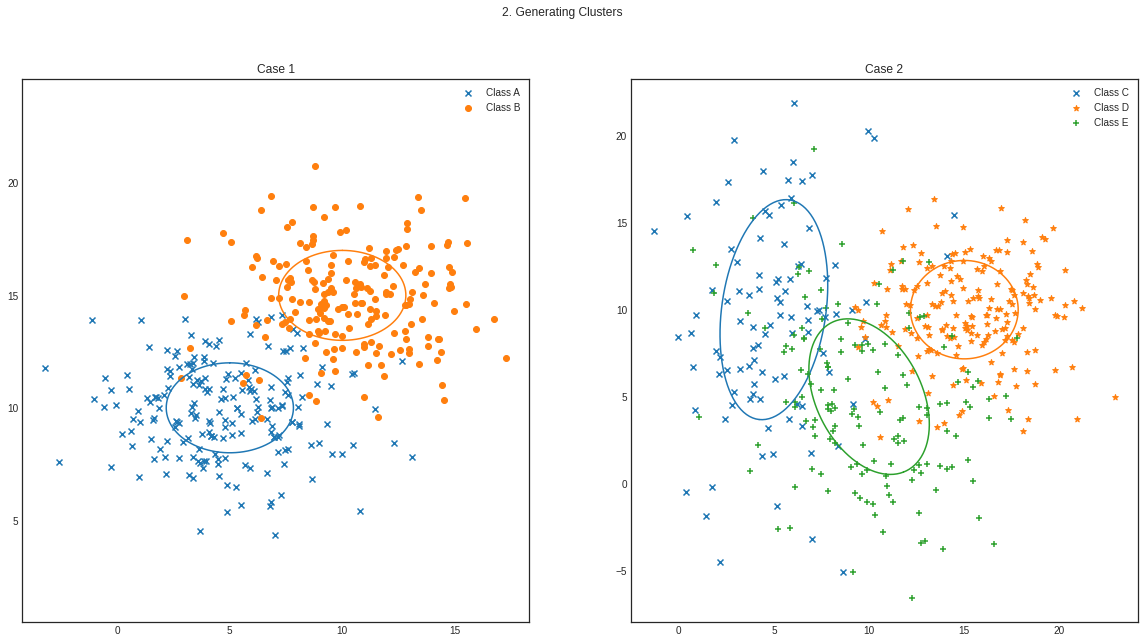

In [4]:
# plot

plt.style.use('seaborn-white')
fig, ax = plt.subplots(1, 2)
fig.suptitle("2. Generating Clusters")
fig.set_figwidth(20)
fig.set_figheight(10)

# Case 1 Plot
ax[0].scatter(datA[0, :], datA[1, :], marker='x', label="Class A")
ax[0].scatter(datB[0, :], datB[1, :], marker='o', label="Class B")
ax[0].plot(contourA[0, :], contourA[1, :])
ax[0].plot(contourB[0, :], contourB[1, :])
ax[0].axis('equal')
ax[0].set_title("Case 1")
ax[0].legend()

# Case 2 Plot
ax[1].scatter(datC[0, :], datC[1, :], marker='x', label="Class C")
ax[1].scatter(datD[0, :], datD[1, :], marker='*', label="Class D")
ax[1].scatter(datE[0, :], datE[1, :], marker='+', label="Class E")
ax[1].plot(contourC[0, :], contourC[1, :])
ax[1].plot(contourD[0, :], contourD[1, :])
ax[1].plot(contourE[0, :], contourE[1, :])
ax[1].axis('auto')
ax[1].set_title("Case 2")
ax[1].legend()

## 3. Classifiers

In [5]:
class MEDclassifier:
  def __init__(self, classMeans):
    self.classMeans = classMeans
    self.nClasses = classMeans.shape[0]

  def euclidean_distance(self, a, b):
    return math.sqrt(((a[0]-b[0])**2) + ((a[1]-b[1])**2))

  def classify(self,x):
    probs = np.zeros(self.nClasses)
    for i in range(len(probs)):
      probs[i] = self.euclidean_distance(self.classMeans[i],x)
    return argmin(probs)


class GEDclassifier:
    def __init__(self, classMeans, classCovs):
      self.classMeans = classMeans
      self.distances = []
      self.classCovs = classCovs
      self.weights = np.linalg.inv(self.classCovs)
      self.nClasses = classMeans.shape[0]

    def euclidean_distance(self,a, b, w):
      x = (a - b).T @ (w) @ (a - b)
      return x 
      
    def classify(self,x):
      probs = [0] * self.nClasses
      for i in range(self.nClasses):
        probs[i] = self.euclidean_distance(self.classMeans[i],x, self.weights[i])
      return argmin(probs)


In [6]:
def NormPDF(x, means, cov):
  n = len(x)
  m = -0.5 * np.transpose(x-means) @ np.linalg.inv(cov) @ (x-means)
  c = 1 / math.sqrt( (2*math.pi)**n * np.linalg.det(cov))
  prob = c * np.exp(m)
  return prob


class MAPClassifier:
  def __init__(self, classMeans, classCovs, classPriors):
    self.classMeans = classMeans
    self.classCovs = classCovs
    self.classPriors = classPriors

    self.nClasses = classMeans.shape[0]

  def classify(self,x):
    # calculate p(x|Ci)*P(Ci) for each class
    # select the maximum
    probs = np.zeros(self.nClasses)
    for i in range(self.nClasses):
      # Using the normal pdf 
      probs[i] = self.classPriors[i] * NormPDF(x, self.classMeans[i,:], self.classCovs[i,:,:])
    pred = argmax(probs)
    return pred


In [7]:
# Set Class Parameters
means1 = np.array([[[5], [10]],[[10], [15]]])
cov1 = np.array([[[8, 0], [0, 4]],[[8, 0], [0, 4]]])
priors1 = np.array([[200/400], [200/400]])

means2 = np.array([[[5],[10]],[[15],[10]],[[10],[5]]])
cov2 = np.array([[[8,4],[4,40]],[[8,0],[0,8]],[[10,-5],[-5,20]]])
priors2 = np.array([[100/450],[200/450],[150/450]])

# Build models
MAP1 = MAPClassifier(means1, cov1, priors1)
MAP2 = MAPClassifier(means2, cov2, priors2)
MED1 = MEDclassifier(means1)
MED2 = MEDclassifier(means2)
GED1 = GEDclassifier(means1,cov1)
GED2 = GEDclassifier(means2,cov2)

<ipython-input-8-fb3ecf38b0a0>:36: UserWarning: The following kwargs were not used by contour: 'color'
  ax[0].contour(C1x1Vals, C1x2Vals, MEDpredGrid1.T, color='blue')
<ipython-input-8-fb3ecf38b0a0>:45: UserWarning: The following kwargs were not used by contour: 'color'
  ax[1].contour(C2x1Vals, C2x2Vals, MEDpredGrid2.T, color='blue')
<ipython-input-8-fb3ecf38b0a0>:155: UserWarning: The following kwargs were not used by contour: 'labels'
  ax[1].contour(C2x1Vals, C2x2Vals, MAPpredGrid2.T, colors='blue', labels='MAP')


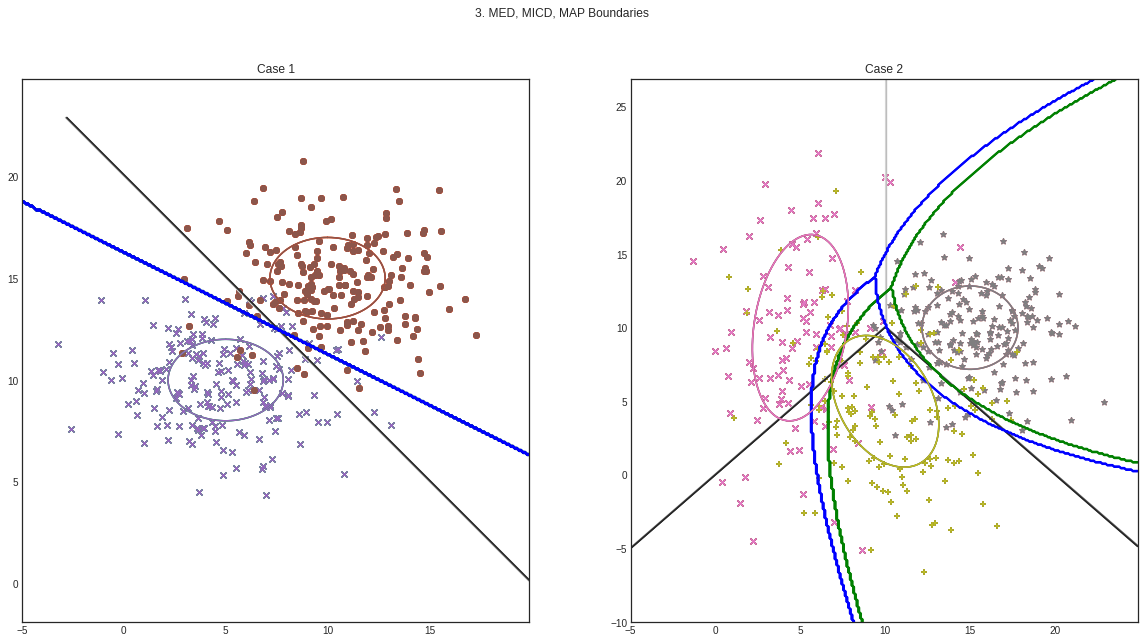

In [8]:
#Generate grid data for classification boundaries
stepSize = 0.1
C1x1Lims = [-5, 20]
C1x2Lims = [0, 23]
C1x1Vals = np.arange(C1x1Lims[0], C1x1Lims[1], stepSize)
C1x2Vals = np.arange(C1x2Lims[0], C1x2Lims[1], stepSize)
MEDpredGrid1 = np.zeros((len(C1x1Vals),len(C1x2Vals)))

C2x1Lims = [-5, 25]
C2x2Lims = [-10, 27]
C2x1Vals = np.arange(C2x1Lims[0], C2x1Lims[1], stepSize)
C2x2Vals = np.arange(C2x2Lims[0], C2x2Lims[1], stepSize)
MEDpredGrid2 = np.zeros((len(C2x1Vals),len(C2x2Vals)))

for i1 in range(len(C1x1Vals)):
  x1 = C1x1Vals[i1]
  for i2 in range(len(C1x2Vals)):
    x2 = C1x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    MEDpredGrid1[i1, i2] = MED1.classify(pattern)

for i1 in range(len(C2x1Vals)):
  x1 = C2x1Vals[i1]
  for i2 in range(len(C2x2Vals)):
    x2 = C2x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    MEDpredGrid2[i1, i2] = MED2.classify(pattern)

plt.style.use('seaborn-white')
fig, ax = plt.subplots(1, 2)
fig.suptitle("3. MED, MICD, MAP Boundaries")
fig.set_figwidth(20)
fig.set_figheight(10)

# Case 1 Plot
ax[0].contour(C1x1Vals, C1x2Vals, MEDpredGrid1.T, color='blue')
ax[0].scatter(datA[0, :], datA[1, :], marker='x')
ax[0].scatter(datB[0, :], datB[1, :], marker='o')
ax[0].plot(contourA[0, :], contourA[1, :])
ax[0].plot(contourB[0, :], contourB[1, :])
ax[0].axis('equal')
ax[0].set_title("Case 1")

# Case 2 Plot
ax[1].contour(C2x1Vals, C2x2Vals, MEDpredGrid2.T, color='blue')
ax[1].scatter(datC[0, :], datC[1, :], marker='x')
ax[1].scatter(datD[0, :], datD[1, :], marker='*')
ax[1].scatter(datE[0, :], datE[1, :], marker='+')
ax[1].plot(contourC[0, :], contourC[1, :])
ax[1].plot(contourD[0, :], contourD[1, :])
ax[1].plot(contourE[0, :], contourE[1, :])
ax[1].axis('auto')
ax[1].set_title("Case 2")

#Generate grid data for classification boundaries

stepSize = 0.1
C1x1Lims = [-5, 20]
C1x2Lims = [0, 23]
C1x1Vals = np.arange(C1x1Lims[0], C1x1Lims[1], stepSize)
C1x2Vals = np.arange(C1x2Lims[0], C1x2Lims[1], stepSize)
GEDpredGrid1 = np.zeros((len(C1x1Vals),len(C1x2Vals)))

C2x1Lims = [-5, 25]
C2x2Lims = [-10, 27]
C2x1Vals = np.arange(C2x1Lims[0], C2x1Lims[1], stepSize)
C2x2Vals = np.arange(C2x2Lims[0], C2x2Lims[1], stepSize)
GEDpredGrid2 = np.zeros((len(C2x1Vals),len(C2x2Vals)))

for i1 in range(len(C1x1Vals)):
  x1 = C1x1Vals[i1]
  for i2 in range(len(C1x2Vals)):
    x2 = C1x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    GEDpredGrid1[i1, i2] = GED1.classify(pattern)

for i1 in range(len(C2x1Vals)):
  x1 = C2x1Vals[i1]
  for i2 in range(len(C2x2Vals)):
    x2 = C2x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    GEDpredGrid2[i1, i2] = GED2.classify(pattern)

# plt.style.use('seaborn-white')
# fig, ax = plt.subplots(1, 2)
# fig.suptitle("3. MED, MICD, MAP Boundaries")
# fig.set_figwidth(20)
# fig.set_figheight(10)

# Case 1 Plot
ax[0].contour(C1x1Vals, C1x2Vals, GEDpredGrid1.T, colors='green')
ax[0].scatter(datA[0, :], datA[1, :], marker='x')
ax[0].scatter(datB[0, :], datB[1, :], marker='o')
ax[0].plot(contourA[0, :], contourA[1, :])
ax[0].plot(contourB[0, :], contourB[1, :])
ax[0].axis('equal')
ax[0].set_title("Case 1")

# Case 2 Plot
ax[1].contour(C2x1Vals, C2x2Vals, GEDpredGrid2.T, colors='green')
ax[1].scatter(datC[0, :], datC[1, :], marker='x')
ax[1].scatter(datD[0, :], datD[1, :], marker='*')
ax[1].scatter(datE[0, :], datE[1, :], marker='+')
ax[1].plot(contourC[0, :], contourC[1, :])
ax[1].plot(contourD[0, :], contourD[1, :])
ax[1].plot(contourE[0, :], contourE[1, :])
ax[1].axis('auto')
ax[1].set_title("Case 2")

#Generate grid data for classification boundaries

stepSize = 0.1
C1x1Lims = [-5, 20]
C1x2Lims = [0, 23]
C1x1Vals = np.arange(C1x1Lims[0], C1x1Lims[1], stepSize)
C1x2Vals = np.arange(C1x2Lims[0], C1x2Lims[1], stepSize)
MAPpredGrid1 = np.zeros((len(C1x1Vals),len(C1x2Vals)))

C2x1Lims = [-5, 25]
C2x2Lims = [-10, 27]
C2x1Vals = np.arange(C2x1Lims[0], C2x1Lims[1], stepSize)
C2x2Vals = np.arange(C2x2Lims[0], C2x2Lims[1], stepSize)
MAPpredGrid2 = np.zeros((len(C2x1Vals),len(C2x2Vals)))

for i1 in range(len(C1x1Vals)):
  x1 = C1x1Vals[i1]
  for i2 in range(len(C1x2Vals)):
    x2 = C1x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    MAPpredGrid1[i1, i2] = MAP1.classify(pattern)

for i1 in range(len(C2x1Vals)):
  x1 = C2x1Vals[i1]
  for i2 in range(len(C2x2Vals)):
    x2 = C2x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    MAPpredGrid2[i1, i2] = MAP2.classify(pattern)

# plt.style.use('seaborn-white')
# fig, ax = plt.subplots(1, 2)
# fig.suptitle("3. MED, MICD, MAP Boundaries")
# fig.set_figwidth(20)
# fig.set_figheight(10)

# Case 1 Plot
ax[0].contour(C1x1Vals, C1x2Vals, MAPpredGrid1.T, colors='blue')
ax[0].scatter(datA[0, :], datA[1, :], marker='x')
ax[0].scatter(datB[0, :], datB[1, :], marker='o')
ax[0].plot(contourA[0, :], contourA[1, :])
ax[0].plot(contourB[0, :], contourB[1, :])
ax[0].axis('equal')
ax[0].set_title("Case 1")

# Case 2 Plot
ax[1].contour(C2x1Vals, C2x2Vals, MAPpredGrid2.T, colors='blue', labels='MAP')
ax[1].scatter(datC[0, :], datC[1, :], marker='x')
ax[1].scatter(datD[0, :], datD[1, :], marker='*')
ax[1].scatter(datE[0, :], datE[1, :], marker='+')
ax[1].plot(contourC[0, :], contourC[1, :])
ax[1].plot(contourD[0, :], contourD[1, :])
ax[1].plot(contourE[0, :], contourE[1, :])
ax[1].axis('auto')
ax[1].set_title("Case 2")
ax[1].legend()

  



Text(0.5, 1.0, 'Case 2')

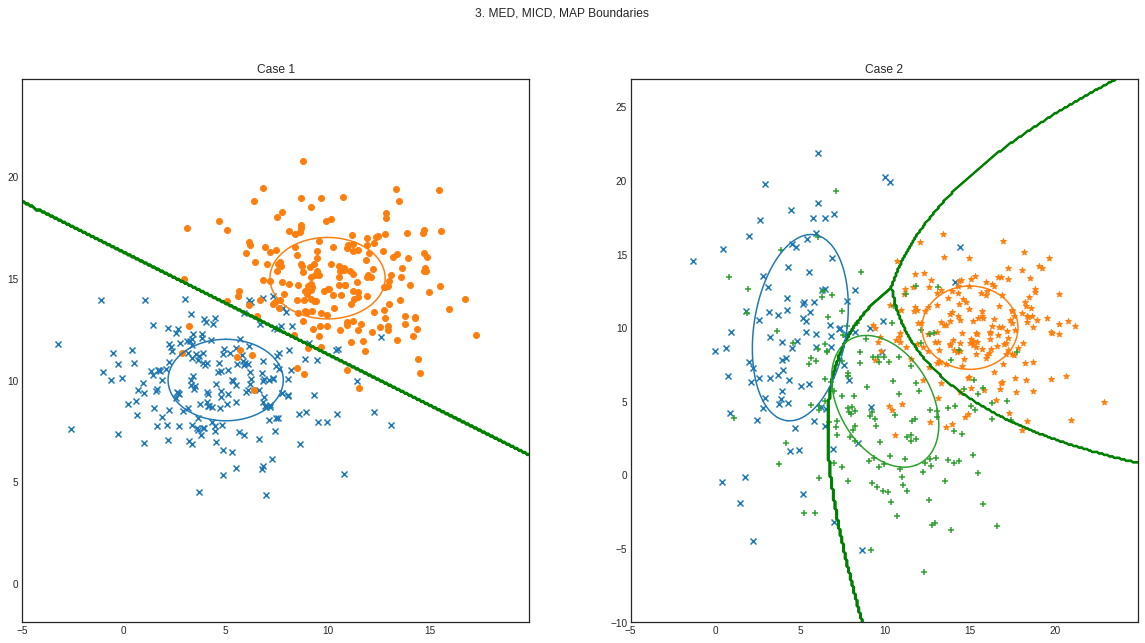

In [9]:
#Generate grid data for classification boundaries
stepSize = 0.1
C1x1Lims = [-5, 20]
C1x2Lims = [0, 23]
C1x1Vals = np.arange(C1x1Lims[0], C1x1Lims[1], stepSize)
C1x2Vals = np.arange(C1x2Lims[0], C1x2Lims[1], stepSize)
GEDpredGrid1 = np.zeros((len(C1x1Vals),len(C1x2Vals)))

C2x1Lims = [-5, 25]
C2x2Lims = [-10, 27]
C2x1Vals = np.arange(C2x1Lims[0], C2x1Lims[1], stepSize)
C2x2Vals = np.arange(C2x2Lims[0], C2x2Lims[1], stepSize)
GEDpredGrid2 = np.zeros((len(C2x1Vals),len(C2x2Vals)))

for i1 in range(len(C1x1Vals)):
  x1 = C1x1Vals[i1]
  for i2 in range(len(C1x2Vals)):
    x2 = C1x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    GEDpredGrid1[i1, i2] = GED1.classify(pattern)

for i1 in range(len(C2x1Vals)):
  x1 = C2x1Vals[i1]
  for i2 in range(len(C2x2Vals)):
    x2 = C2x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    GEDpredGrid2[i1, i2] = GED2.classify(pattern)

plt.style.use('seaborn-white')
fig, ax = plt.subplots(1, 2)
fig.suptitle("3. MED, MICD, MAP Boundaries")
fig.set_figwidth(20)
fig.set_figheight(10)

# Case 1 Plot
ax[0].contour(C1x1Vals, C1x2Vals, GEDpredGrid1.T, colors='green')
ax[0].scatter(datA[0, :], datA[1, :], marker='x')
ax[0].scatter(datB[0, :], datB[1, :], marker='o')
ax[0].plot(contourA[0, :], contourA[1, :])
ax[0].plot(contourB[0, :], contourB[1, :])
ax[0].axis('equal')
ax[0].set_title("Case 1")

# Case 2 Plot
ax[1].contour(C2x1Vals, C2x2Vals, GEDpredGrid2.T, colors='green')
ax[1].scatter(datC[0, :], datC[1, :], marker='x')
ax[1].scatter(datD[0, :], datD[1, :], marker='*')
ax[1].scatter(datE[0, :], datE[1, :], marker='+')
ax[1].plot(contourC[0, :], contourC[1, :])
ax[1].plot(contourD[0, :], contourD[1, :])
ax[1].plot(contourE[0, :], contourE[1, :])
ax[1].axis('auto')
ax[1].set_title("Case 2")

  

Text(0.5, 1.0, 'Case 2')

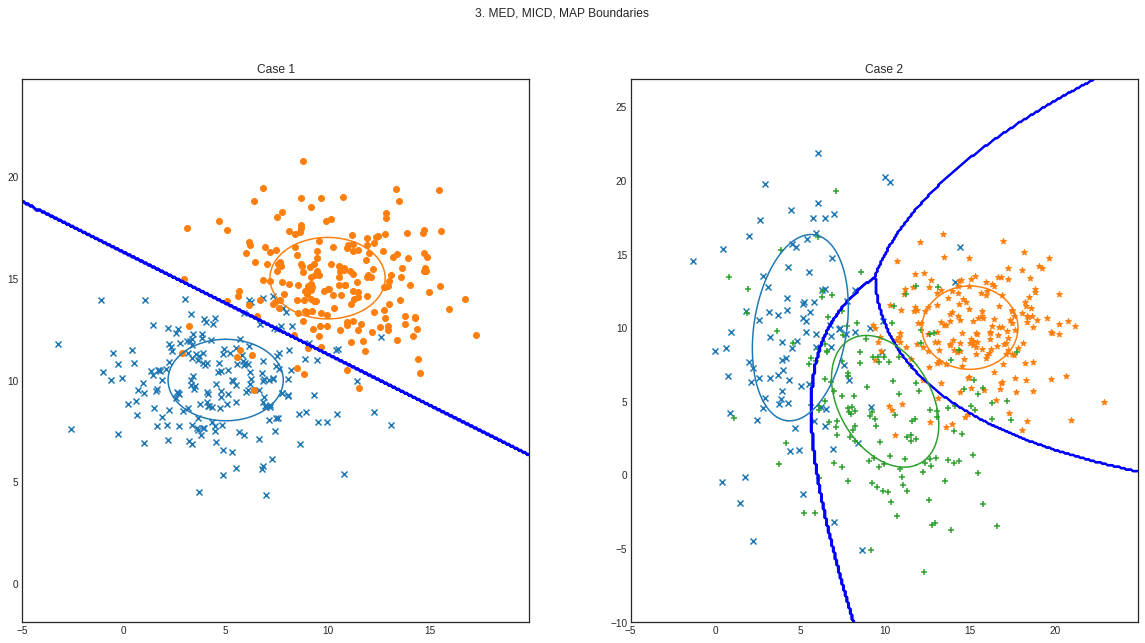

In [10]:
#Generate grid data for classification boundaries

stepSize = 0.1
C1x1Lims = [-5, 20]
C1x2Lims = [0, 23]
C1x1Vals = np.arange(C1x1Lims[0], C1x1Lims[1], stepSize)
C1x2Vals = np.arange(C1x2Lims[0], C1x2Lims[1], stepSize)
MAPpredGrid1 = np.zeros((len(C1x1Vals),len(C1x2Vals)))

C2x1Lims = [-5, 25]
C2x2Lims = [-10, 27]
C2x1Vals = np.arange(C2x1Lims[0], C2x1Lims[1], stepSize)
C2x2Vals = np.arange(C2x2Lims[0], C2x2Lims[1], stepSize)
MAPpredGrid2 = np.zeros((len(C2x1Vals),len(C2x2Vals)))

for i1 in range(len(C1x1Vals)):
  x1 = C1x1Vals[i1]
  for i2 in range(len(C1x2Vals)):
    x2 = C1x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    MAPpredGrid1[i1, i2] = MAP1.classify(pattern)

for i1 in range(len(C2x1Vals)):
  x1 = C2x1Vals[i1]
  for i2 in range(len(C2x2Vals)):
    x2 = C2x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    MAPpredGrid2[i1, i2] = MAP2.classify(pattern)

plt.style.use('seaborn-white')
fig, ax = plt.subplots(1, 2)
fig.suptitle("3. MED, MICD, MAP Boundaries")
fig.set_figwidth(20)
fig.set_figheight(10)

# Case 1 Plot
ax[0].contour(C1x1Vals, C1x2Vals, MAPpredGrid1.T, colors='blue')
ax[0].scatter(datA[0, :], datA[1, :], marker='x')
ax[0].scatter(datB[0, :], datB[1, :], marker='o')
ax[0].plot(contourA[0, :], contourA[1, :])
ax[0].plot(contourB[0, :], contourB[1, :])
ax[0].axis('equal')
ax[0].set_title("Case 1")

# Case 2 Plot
ax[1].contour(C2x1Vals, C2x2Vals, MAPpredGrid2.T, colors='blue')
ax[1].scatter(datC[0, :], datC[1, :], marker='x')
ax[1].scatter(datD[0, :], datD[1, :], marker='*')
ax[1].scatter(datE[0, :], datE[1, :], marker='+')
ax[1].plot(contourC[0, :], contourC[1, :])
ax[1].plot(contourD[0, :], contourD[1, :])
ax[1].plot(contourE[0, :], contourE[1, :])
ax[1].axis('auto')
ax[1].set_title("Case 2")

  



In [11]:
class kNN():
  def __init__(self, datas, k=1):
    """
    Constructs a kNN classifier

    :param k: k param of kNN
    :param datas: list of data-arrays sorted by lowest class index (0, 1, ... N)
    """
    self.datas = dict()
    self.k = k

    # class to data mapping dictionary
    for i, data in enumerate(datas):
      self.datas.update({i: data})

  def euclidean_distance(self, a, b):
    return math.sqrt(((a[0]-b[0])**2) + ((a[1]-b[1])**2))

  def classify(self, pattern):
    distances = dict()

    for target in self.datas.keys():
      individual_distances = [self.euclidean_distance(pattern, val) for val in self.datas[target].T]
      sorted_points = np.array([x for _, x in sorted(zip(individual_distances, self.datas[target].T), key=lambda pair: pair[0])])
      prototype = np.mean(sorted_points[:self.k], axis=0)
      distances.update({target: self.euclidean_distance(pattern, prototype)})

    return min(distances, key=distances.get)


# note that NN is just kNN with the restraint that k=1

<ipython-input-12-e433c1c094b7>:59: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(C1x1Vals, C1x2Vals, NNpredGrid1.T, colors='blue', label="NN")
<ipython-input-12-e433c1c094b7>:60: UserWarning: The following kwargs were not used by contour: 'label'
  ax[0].contour(C1x1Vals, C1x2Vals, kNNpredGrid1.T, colors='red', label="5NN")
<ipython-input-12-e433c1c094b7>:69: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(C2x1Vals, C2x2Vals, NNpredGrid2.T, colors='blue', label="NN")
<ipython-input-12-e433c1c094b7>:70: UserWarning: The following kwargs were not used by contour: 'label'
  ax[1].contour(C2x1Vals, C2x2Vals, kNNpredGrid2.T, colors='red', label="5NN")


Text(0.5, 1.0, 'Case 2 - NN (blue) 5NN (red)')

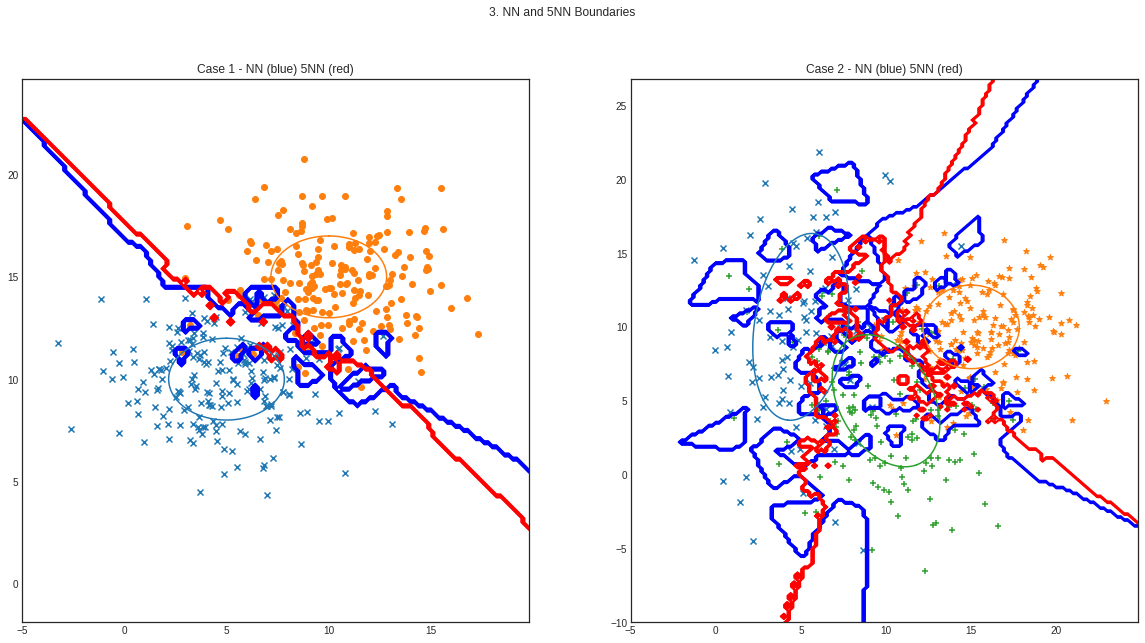

In [12]:
#Generate grid data for classification boundaries

stepSize = 0.2
C1x1Lims = [-5, 20]
C1x2Lims = [0, 23]
C1x1Vals = np.arange(C1x1Lims[0], C1x1Lims[1], stepSize)
C1x2Vals = np.arange(C1x2Lims[0], C1x2Lims[1], stepSize)

C2x1Lims = [-5, 25]
C2x2Lims = [-10, 27]
C2x1Vals = np.arange(C2x1Lims[0], C2x1Lims[1], stepSize)
C2x2Vals = np.arange(C2x2Lims[0], C2x2Lims[1], stepSize)

NNpredGrid1 = np.zeros((len(C1x1Vals),len(C1x2Vals)))
NNpredGrid2 = np.zeros((len(C2x1Vals),len(C2x2Vals)))
kNNpredGrid1 = np.zeros((len(C1x1Vals),len(C1x2Vals)))
kNNpredGrid2 = np.zeros((len(C2x1Vals),len(C2x2Vals)))

NN_1 = kNN([datA, datB], k=1)
NN_2 = kNN([datC, datD, datE], k=1)
kNN_1 = kNN([datA, datB], k=10)
kNN_2 = kNN([datC, datD, datE], k=10)

for i1 in range(len(C1x1Vals)):
  x1 = C1x1Vals[i1]
  for i2 in range(len(C1x2Vals)):
    x2 = C1x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    NNpredGrid1[i1, i2] = NN_1.classify(pattern)

for i1 in range(len(C2x1Vals)):
  x1 = C2x1Vals[i1]
  for i2 in range(len(C2x2Vals)):
    x2 = C2x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    NNpredGrid2[i1, i2] = NN_2.classify(pattern)

for i1 in range(len(C1x1Vals)):
  x1 = C1x1Vals[i1]
  for i2 in range(len(C1x2Vals)):
    x2 = C1x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    kNNpredGrid1[i1, i2] = kNN_1.classify(pattern)

for i1 in range(len(C2x1Vals)):
  x1 = C2x1Vals[i1]
  for i2 in range(len(C2x2Vals)):
    x2 = C2x2Vals[i2]
    pattern = np.array([[x1],[x2]])
    kNNpredGrid2[i1, i2] = kNN_2.classify(pattern)

plt.style.use('seaborn-white')
fig, ax = plt.subplots(1, 2)
fig.suptitle("3. NN and 5NN Boundaries")
fig.set_figwidth(20)
fig.set_figheight(10)

# Case 1 Plot
ax[0].contour(C1x1Vals, C1x2Vals, NNpredGrid1.T, colors='blue', label="NN")
ax[0].contour(C1x1Vals, C1x2Vals, kNNpredGrid1.T, colors='red', label="5NN")
ax[0].scatter(datA[0, :], datA[1, :], marker='x')
ax[0].scatter(datB[0, :], datB[1, :], marker='o')
ax[0].plot(contourA[0, :], contourA[1, :])
ax[0].plot(contourB[0, :], contourB[1, :])
ax[0].axis('equal')
ax[0].set_title("Case 1 - NN (blue) 5NN (red)")

# Case 2 Plot
ax[1].contour(C2x1Vals, C2x2Vals, NNpredGrid2.T, colors='blue', label="NN")
ax[1].contour(C2x1Vals, C2x2Vals, kNNpredGrid2.T, colors='red', label="5NN")
ax[1].scatter(datC[0, :], datC[1, :], marker='x')
ax[1].scatter(datD[0, :], datD[1, :], marker='*')
ax[1].scatter(datE[0, :], datE[1, :], marker='+')
ax[1].plot(contourC[0, :], contourC[1, :])
ax[1].plot(contourD[0, :], contourD[1, :])
ax[1].plot(contourE[0, :], contourE[1, :])
ax[1].axis('auto')
ax[1].set_title("Case 2 - NN (blue) 5NN (red)")

## 4. Error Analysis

In [ ]:
def genCase1_test(dat = None):
  # dat: provided coordinates in standardized space to be converted 
  if dat is None:
    nA = int(200*0.25)
    datA = np.random.randn(2, nA)
    nB = int(200*0.25)
    datB = np.random.randn(2, nB)
  else: 
    datA = dat
    datB = dat


  # parameters
  
  muA = np.array([[5], [10]])
  covA = np.array([[8, 0], [0, 4]])

  muB = np.array([[10], [15]])
  covB = np.array([[8, 0], [0, 4]])

  # decompose covariance matrix to L L^T
  decA = np.linalg.cholesky(covA)
  decB = np.linalg.cholesky(covB)

  # generate
  datA = np.matmul(decA, datA) + muA
  datB = np.matmul(decB, datB) + muB

  return datA, datB

def genCase2_test(dat = None):
  # dat: provided coordinates in standardized space to be converted 
  if dat is None: 
    datC = np.random.randn(2, int(100*0.25))
    datD = np.random.randn(2, int(200*0.25))
    datE = np.random.randn(2, int(150*0.25))
  else: 
    datC = dat
    datD = dat
    datE = dat

  # parameters
  covC = np.array([[8, 4], [4, 40]])
  covD = np.array([[8, 0], [0, 8]])
  covE = np.array([[10,-5], [-5, 20]])

  # decompose covariance matrix to L L^T
  decC = np.linalg.cholesky(covC)
  decD = np.linalg.cholesky(covD)
  decE = np.linalg.cholesky(covE)

  datC = np.matmul(decC, datC) + np.array([[5], [10]]) 

  datD = np.matmul(decD, datD) + np.array([[15], [10]]) 

  datE = np.matmul(decE, datE) + np.array([[10], [5]]) 

  return datC, datD, datE


test_datA, test_datB = genCase1_test()
test_datC, test_datD, test_datE = genCase2_test()


# NN and 5NN preds
kNN_df = pd.DataFrame(columns=['Case', 'x', 'Class', 'NN', '5NN'])

for point in test_datA.T:
  kNN_df = kNN_df.append({'Case'    : 1
             ,'x'        : point
             ,'Class'    : 0
             ,'NNpred'  : NN_1.classify([[point[0]], [point[1]]]) 
             ,'kNNpred'  : kNN_1.classify([[point[0]], [point[1]]])                          
             }, ignore_index=True)

for point in test_datB.T:
  kNN_df = kNN_df.append({'Case'    : 1
             ,'x'        : point
             ,'Class'    : 1
             ,'NNpred'  : NN_1.classify([[point[0]], [point[1]]]) 
             ,'kNNpred'  : kNN_1.classify([[point[0]], [point[1]]])                          
             }, ignore_index=True)
  
for point in test_datC.T:
  kNN_df = kNN_df.append({'Case'    : 2
             ,'x'        : point
             ,'Class'    : 0
             ,'NNpred'  : NN_2.classify([[point[0]], [point[1]]]) 
             ,'kNNpred'  : kNN_2.classify([[point[0]], [point[1]]])                          
             }, ignore_index=True)
  
for point in test_datD.T:
  kNN_df = kNN_df.append({'Case'    : 2
             ,'x'        : point
             ,'Class'    : 1
             ,'NNpred'  : NN_2.classify([[point[0]], [point[1]]]) 
             ,'kNNpred'  : kNN_2.classify([[point[0]], [point[1]]])     
             }, ignore_index=True)
  
for point in test_datE.T:
  kNN_df = kNN_df.append({'Case'    : 2
             ,'x'        : point
             ,'Class'    : 2
             ,'NNpred'  : NN_2.classify([[point[0]], [point[1]]]) 
             ,'kNNpred'  : kNN_2.classify([[point[0]], [point[1]]])     
             }, ignore_index=True)




In [ ]:
def ConfusionMatrix(predVal, trueVal, nClasses, normalize=True):
  confusion = np.zeros((nClasses, nClasses))
  for i in range(len(predVal)):
    confusion[int(trueVal[i]), int(predVal[i])] += 1

  if normalize==True:
    for i in range(nClasses):
      classTotal = 0
      for j in range(nClasses):
        classTotal+=confusion[i,j]
      confusion[i,:] = confusion[i, :]/classTotal

  return confusion


def ErrorRate(predVal, trueVal):
  incorrect = 0
  totalPred = len(predVal)
  for i in range(len(predVal)):
    if predVal[i] != trueVal[i]:
      incorrect+=1

  return incorrect/totalPred

In [15]:
# MAP, MED, and MICD data and predictions
df = pd.DataFrame(columns=['Case', 'x', 'Class', 'MAPpred', 'MEDpred', 'MICDpred'])

for point in datA.T:
  df = df.append({'Case'    : 1
             ,'x'        : point
             ,'Class'    : 0
             ,'MAPpred'  : MAP1.classify([[point[0]], [point[1]]]) 
             ,'MEDpred'  : MED1.classify([[point[0]], [point[1]]])                     
             ,'MICDpred' : GED1.classify([[point[0]], [point[1]]])         
             }, ignore_index=True)

for point in datB.T:
  df = df.append({'Case'    : 1
             ,'x'        : point
             ,'Class'    : 1
             ,'MAPpred'  : MAP1.classify([[point[0]], [point[1]]]) 
             ,'MEDpred'  : MED1.classify([[point[0]], [point[1]]])             
             ,'MICDpred' : GED1.classify([[point[0]], [point[1]]])   
             }, ignore_index=True)
  
for point in datC.T:
  df = df.append({'Case'    : 2
             ,'x'        : point
             ,'Class'    : 0
             ,'MAPpred'  : MAP2.classify([[point[0]], [point[1]]]) 
             ,'MEDpred'  : MED2.classify([[point[0]], [point[1]]])              
             ,'MICDpred' : GED2.classify([[point[0]], [point[1]]])
             }, ignore_index=True)
  
for point in datD.T:
  df = df.append({'Case'    : 2
             ,'x'        : point
             ,'Class'    : 1
             ,'MAPpred'  : MAP2.classify([[point[0]], [point[1]]]) 
             ,'MEDpred'  : MED2.classify([[point[0]], [point[1]]])            
             ,'MICDpred' : GED2.classify([[point[0]], [point[1]]])
             }, ignore_index=True)
  
for point in datE.T:
  df = df.append({'Case'    : 2
             ,'x'        : point
             ,'Class'    : 2
             ,'MAPpred'  : MAP2.classify([[point[0]], [point[1]]]) 
             ,'MEDpred'  : MED2.classify([[point[0]], [point[1]]])        
             ,'MICDpred' : GED2.classify([[point[0]], [point[1]]])
             }, ignore_index=True)

In [16]:
df1 = df.query("Case==1")
preds1 = df1.loc[:,'MICDpred'].array
class1 = df1.loc[:,'Class'].array

df2 = df.query("Case==2")
preds2 = df2.loc[:,'MICDpred'].array
class2 = df2.loc[:,'Class'].array

cmMED1 = ConfusionMatrix(preds1, class1, 2)
cmMED2 = ConfusionMatrix(preds2, class2, 3)

errorRate1 = ErrorRate(preds1, class1)
errorRate2 = ErrorRate(preds2, class2)

print("MED Case 1 error rate: ", errorRate1)
print("MED Case 2 error rate: ", errorRate2)

MED Case 1 error rate:  0.06
MED Case 2 error rate:  0.20666666666666667


In [17]:
kNN_df1 = kNN_df.query("Case==1")
preds1 = kNN_df1.loc[:,'NNpred'].array
class1 = kNN_df1.loc[:,'Class'].array

kNN_df2 = kNN_df.query("Case==2")
preds2 = kNN_df2.loc[:,'NNpred'].array
class2 = kNN_df2.loc[:,'Class'].array

cmNN1 = ConfusionMatrix(preds1, class1, 2)
cmNN2 = ConfusionMatrix(preds2, class2, 3)

errorRate1 = ErrorRate(preds1, class1)
errorRate2 = ErrorRate(preds2, class2)

print("NN Case 1 error rate: ", errorRate1)
print("NN Case 2 error rate: ", errorRate2)

NN Case 1 error rate:  0.06
NN Case 2 error rate:  0.3125


In [18]:
kNN_df1 = kNN_df.query("Case==1")
preds1 = kNN_df1.loc[:,'kNNpred'].array
class1 = kNN_df1.loc[:,'Class'].array

kNN_df2 = kNN_df.query("Case==2")
preds2 = kNN_df2.loc[:,'kNNpred'].array
class2 = kNN_df2.loc[:,'Class'].array

cm5NN1 = ConfusionMatrix(preds1, class1, 2)
cm5NN2 = ConfusionMatrix(preds2, class2, 3)

errorRate1 = ErrorRate(preds1, class1)
errorRate2 = ErrorRate(preds2, class2)

print("5NN Case 1 error rate: ", errorRate1)
print("5NN Case 2 error rate: ", errorRate2)

5NN Case 1 error rate:  0.02
5NN Case 2 error rate:  0.26785714285714285


In [19]:
df1 = df.query("Case==1")
preds1 = df1.loc[:,'MICDpred'].array
class1 = df1.loc[:,'Class'].array

df2 = df.query("Case==2")
preds2 = df2.loc[:,'MICDpred'].array
class2 = df2.loc[:,'Class'].array

cmMICD1 = ConfusionMatrix(preds1, class1, 2)
cmMICD2 = ConfusionMatrix(preds2, class2, 3)

errorRate1 = ErrorRate(preds1, class1)
errorRate2 = ErrorRate(preds2, class2)

print("MICD Case 1 error rate: ", errorRate1)
print("MICD Case 2 error rate: ", errorRate2)

MICD Case 1 error rate:  0.06
MICD Case 2 error rate:  0.20666666666666667


In [20]:
# MAP Confusion Matrices
df1 = df.query("Case==1")
preds1 = df1.loc[:,'MAPpred'].array
class1 = df1.loc[:,'Class'].array

df2 = df.query("Case==2")
preds2 = df2.loc[:,'MAPpred'].array
class2 = df2.loc[:,'Class'].array

cmMAP1 = ConfusionMatrix(preds1, class1, 2)
cmMAP2 = ConfusionMatrix(preds2, class2, 3)

errorRate1 = ErrorRate(preds1, class1)
errorRate2 = ErrorRate(preds2, class2)

print("MAP Case 1 error rate: ", errorRate1)
print("MAP Case 2 error rate: ", errorRate2)


MAP Case 1 error rate:  0.06
MAP Case 2 error rate:  0.18444444444444444


[Text(0.5, 18.5, 'Predicted Class'), Text(36.5, 0.5, 'Actual Class')]

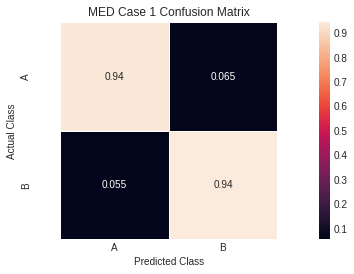

In [21]:
f = sns.heatmap(cmMED1, annot=True, linewidth=0.5, xticklabels=['A', 'B'], yticklabels=['A', 'B'])
f.axis('equal')
f.set_title("MED Case 1 Confusion Matrix")
f.set(xlabel="Predicted Class", ylabel="Actual Class")

[Text(0.5, 18.5, 'Predicted Class'), Text(36.5, 0.5, 'Actual Class')]

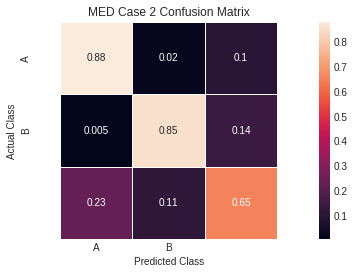

In [22]:
f = sns.heatmap(cmMED2, annot=True, linewidth=0.5, xticklabels=['A', 'B'], yticklabels=['A', 'B'])
f.axis('equal')
f.set_title("MED Case 2 Confusion Matrix")
f.set(xlabel="Predicted Class", ylabel="Actual Class")

[Text(0.5, 18.5, 'Predicted Class'), Text(36.5, 0.5, 'Actual Class')]

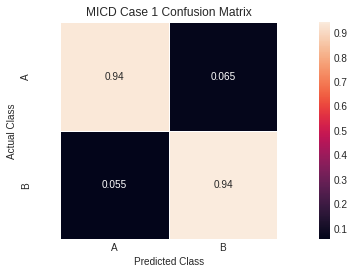

In [23]:
f = sns.heatmap(cmMICD1, annot=True, linewidth=0.5, xticklabels=['A', 'B'], yticklabels=['A', 'B'])
f.axis('equal')
f.set_title("MICD Case 1 Confusion Matrix")
f.set(xlabel="Predicted Class", ylabel="Actual Class")

[Text(0.5, 18.5, 'Predicted Class'), Text(36.5, 0.5, 'Actual Class')]

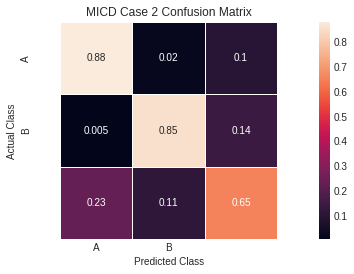

In [24]:
f = sns.heatmap(cmMICD2, annot=True, linewidth=0.5, xticklabels=['A', 'B'], yticklabels=['A', 'B'])
f.axis('equal')
f.set_title("MICD Case 2 Confusion Matrix")
f.set(xlabel="Predicted Class", ylabel="Actual Class")

[Text(0.5, 18.5, 'Predicted Class'), Text(36.5, 0.5, 'Actual Class')]

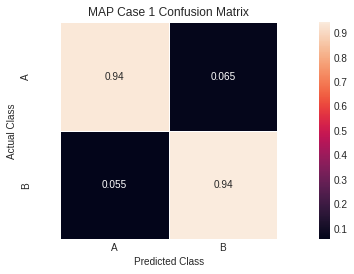

In [25]:
f = sns.heatmap(cmMAP1, annot=True, linewidth=0.5, xticklabels=['A', 'B'], yticklabels=['A', 'B'])
f.axis('equal')
f.set_title("MAP Case 1 Confusion Matrix")
f.set(xlabel="Predicted Class", ylabel="Actual Class")

[Text(0.5, 18.5, 'Predicted Class'), Text(36.5, 0.5, 'Actual Class')]

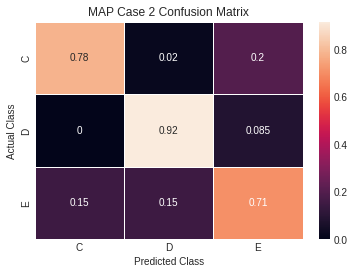

In [26]:
f = sns.heatmap(cmMAP2, annot=True, linewidth=0.5, xticklabels=['C', 'D', 'E'], yticklabels=['C', 'D', 'E'])
f.axis('auto')
f.set_title("MAP Case 2 Confusion Matrix")
f.set(xlabel="Predicted Class", ylabel="Actual Class")

(array([[ 0.,  2.,  8., ..., 11.,  1.,  1.],
        [ 0.,  2.,  8., ..., 16.,  1.,  0.],
        [ 0.,  3.,  5., ...,  9.,  6.,  0.],
        ...,
        [ 0.,  2.,  8., ..., 10.,  1.,  0.],
        [ 1.,  2., 14., ..., 13.,  2.,  1.],
        [ 0.,  1., 11., ..., 15.,  4.,  0.]]),
 array([-3.94993402, -3.17634376, -2.40275351, -1.62916326, -0.855573  ,
        -0.08198275,  0.6916075 ,  1.46519776,  2.23878801,  3.01237826,
         3.78596851]),
 <a list of 200 BarContainer objects>)

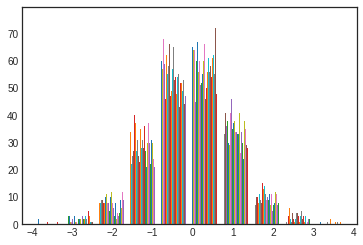

In [27]:
plt.hist(np.random.randn(200, 200))

In [28]:
test_datA, test_datB = genCase1()
test_datC, test_datD, test_datE = genCase2()